In [126]:
from datetime import datetime
import pandas as pd
import requests
import json

# how many bars to get
limit = 100
# timeframe
interval = "1d"

# timeseries technical indicator params
rsi_period = 14

symbols = [
    "BTCUSDT",
    "ETHUSDT",
    "BNBUSDT",
    "ETHBTC",
    "BNBETH",
    "BNBBTC",
]


columns = [
    "Open time",
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "Close time",
    "Quote asset volume",
    "Number of trades",
    "Taker buy base asset volume",
    "Taker buy quote asset volume",
    "Ignore",
]


def get_data(symbol: str, interval: str, limit: int) -> bytes:
    try:
        url = "https://api.binance.com/api/v1/klines"
        params = {"symbol": symbol, "interval": interval, "limit": limit}
        response = requests.get(url, params=params)

        if response.status_code == 200:
            return response
        else:
            response.raise_for_status()
    except Exception as e:
        return e


def calculate_rsi(data: pd.Series, window: int) -> pd.Series:
    """Calculate Relative Strength Index (RSI) using pandas."""
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def assert_fresh_data(response: bytes, symbol: str):
    datapoint = lambda x: datetime.fromtimestamp(json.loads(response)[-1][x]/1000)
    interval = round((datapoint(6)  - datapoint(0)).total_seconds() / 3600)
    now_and_open_time_diff = (
        datetime.utcnow()
        - datapoint(0)
    ).seconds // 3600
    assert now_and_open_time_diff <= interval, f'Data for {symbol} is outdated'

In [127]:
# raw data load
for symbol in symbols:
    with open(f"bronze/{symbol}", "w") as file:
        try:
            print(f"ingesting data for {symbol}")
            response = get_data(symbol, interval, limit)
            assert_fresh_data(response.content, symbol)
            json.dump(json.loads(response.content), file)
        except Exception as e:
            print(e)

ingesting data for BTCUSDT
ingesting data for ETHUSDT
ingesting data for BNBUSDT
ingesting data for ETHBTC
ingesting data for BNBETH
ingesting data for BNBBTC


In [128]:
# silver layer transform
for symbol in symbols:
    with open(f"bronze/{symbol}", "r") as file:
        df = pd.DataFrame(json.loads(file.read()), columns=columns)
        df = df.astype("float")
        datetime_columns = ["Open time", "Close time"]
        for column in datetime_columns:
            df[column] = pd.to_datetime(df[column], unit="ms")
            df[column] = pd.to_datetime(df[column].dt.strftime("%Y-%m-%d %H:%M"))
        df.to_parquet(f"silver/{symbol}.parquet")

In [132]:
# gold layer transform
symbols_and_idx_df = None

for symbol in symbols:
    df = pd.read_parquet(f"silver/{symbol}.parquet")
    df["rsi"] = calculate_rsi(df["Close"], rsi_period)

    df = df.rename(columns={"rsi": symbol})
    rsi = df[[symbol]]
    if symbols_and_idx_df is None:
        symbols_and_idx_df = df[[symbol]]
        continue

    symbols_and_idx_df = symbols_and_idx_df.join(rsi, on=symbols_and_idx_df.index)

# calculate indexes
symbols_and_idx_df["BTC"] = (
    symbols_and_idx_df["BTCUSDT"]
    + (100 - symbols_and_idx_df["ETHBTC"])
    + (100 - symbols_and_idx_df["BNBBTC"])
) / 3
symbols_and_idx_df["ETH"] = (
    symbols_and_idx_df["ETHUSDT"]
    + symbols_and_idx_df["ETHBTC"]
    + (100 - symbols_and_idx_df["BNBETH"])
) / 3
symbols_and_idx_df["BNB"] = (
    symbols_and_idx_df["BNBUSDT"]
    + symbols_and_idx_df["BNBETH"]
    + symbols_and_idx_df["BNBBTC"]
) / 3
symbols_and_idx_df["USDT"] = (
    (100 - symbols_and_idx_df["BTCUSDT"])
    + (100 - symbols_and_idx_df["ETHUSDT"])
    + (100 - symbols_and_idx_df["BNBUSDT"])
) / 3

symbols_and_idx_df.to_parquet(f"gold/data.parquet")

/tmp/ipykernel_32972/1595285458.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_32972/1595285458.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)


[Text(40.0, 0, '40'),
 Text(50.0, 0, '50'),
 Text(60.0, 0, '60'),
 Text(70.0, 0, '70'),
 Text(80.0, 0, '80'),
 Text(90.0, 0, '90'),
 Text(100.0, 0, '100'),
 Text(110.0, 0, '110')]

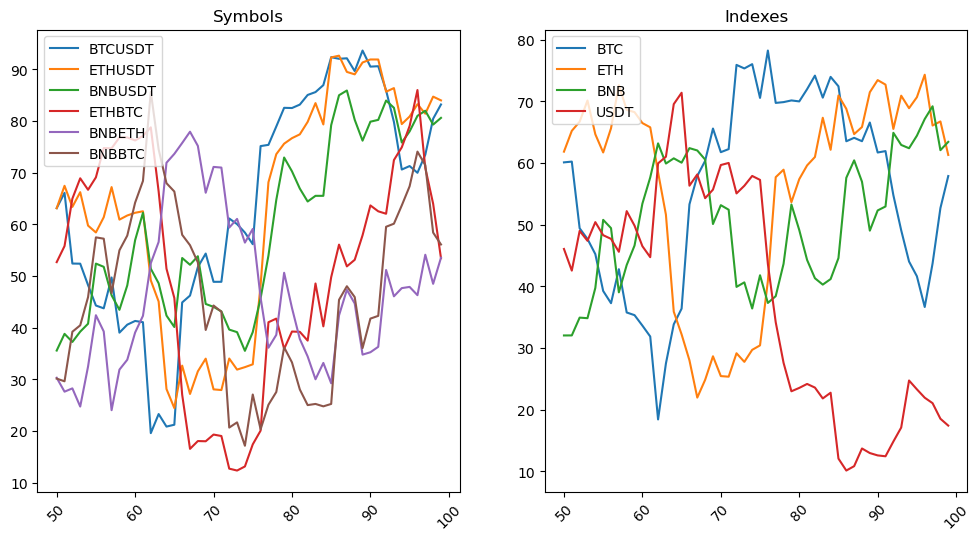

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix for the sliced dataframe
pairs_df = symbols_and_idx_df[symbols]


idxs_df = symbols_and_idx_df.drop(columns=symbols)

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot line graph with solid lines
sns.lineplot(data=pairs_df[50:], dashes=False, ax=axes[0])
axes[0].legend(loc="upper left")
axes[0].set_title("Symbols")
axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=45)

# Plot line graph with solid lines
sns.lineplot(data=idxs_df[50:], dashes=False, ax=axes[1])
axes[1].legend(loc="upper left")
axes[1].set_title("Indexes")
axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)

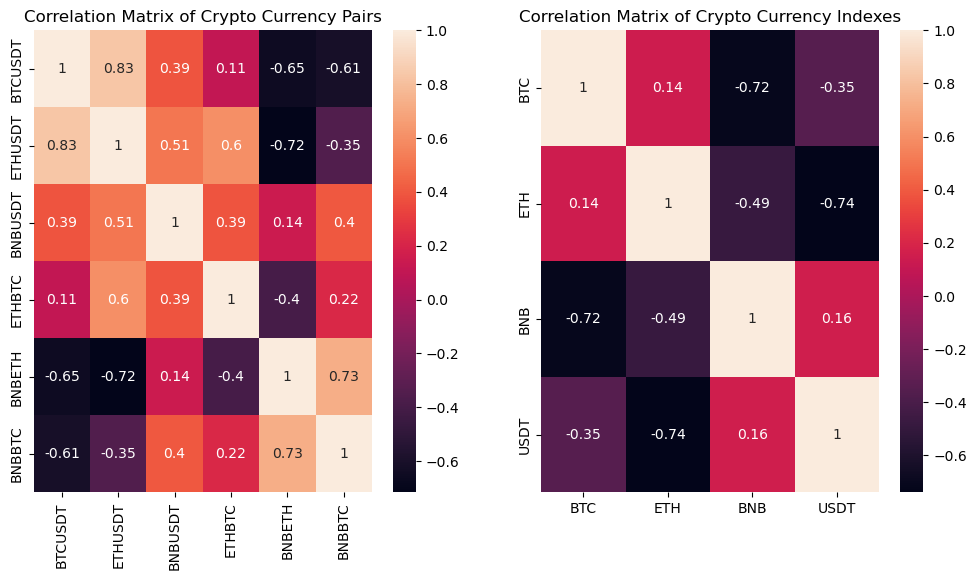

In [131]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot correlation matrix of the sliced dataframe as heatmap in the first subplot
sns.heatmap(pairs_df.reset_index(drop=True).corr(), annot=True, ax=axes[0])
axes[0].set_title("Correlation Matrix of Crypto Currency Pairs")

# Plot correlation matrix of the remaining columns as heatmap in the second subplot
sns.heatmap(idxs_df.reset_index(drop=True).corr(), annot=True, ax=axes[1])
axes[1].set_title("Correlation Matrix of Crypto Currency Indexes")

# Display the plots
plt.show()

<Axes: >

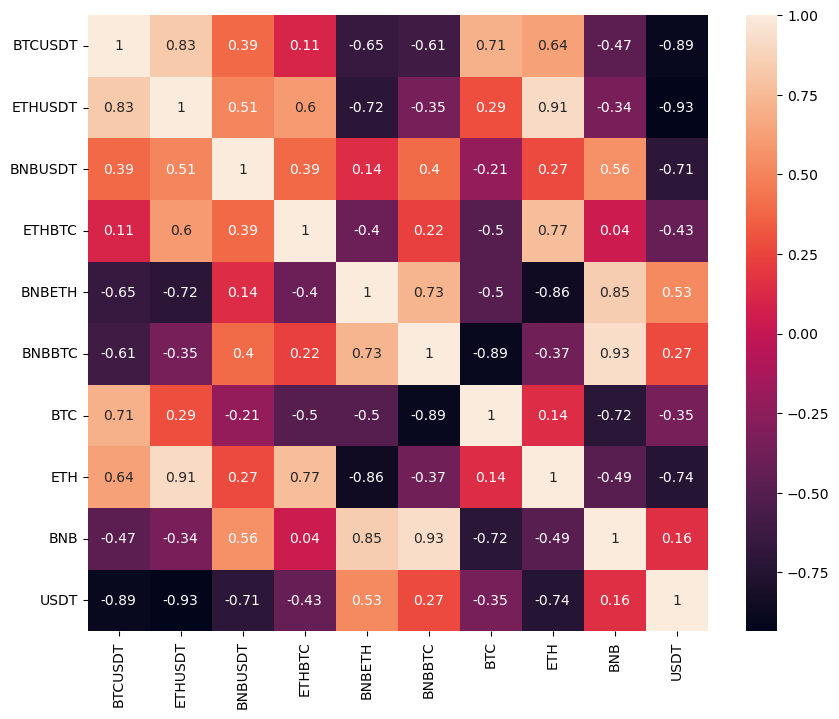

In [125]:
fig, ax = plt.subplots(figsize=(10, 8))

# Create a correlation matrix from the symbols_and_idx_df dataframe
correlation_matrix = symbols_and_idx_df.corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, ax=ax)